# AMME5710 Week 5 Tutorial

This activity is to be completed during the Week 5 tutorial. When you have completed the activity, you will need to show your results to the tutor who will check your work and that you have sufficiently completed the task: this needs to be completed during the tutorial time, so make sure you are ready to show the tutors your work during the last hour of the tutorial

**Tutorial Objectives and Instructions**:
- This tutorial will introduce you to concepts in geometric camera calibration, two-view geometry and stereo vision.
- You should step through the example code snippets which explain and demonstrate the use of relevant functions in OpenCV.
- At the end of the notebook, there are several activities/exercises you will need to complete yourself. You can choose to:
    - Complete these inside the tutorial Jupyter Notebook using python code blocks
    - Write your own python code/scripts to produce the results requested

At any time, you can review the OpenCV documentation [https://docs.opencv.org/4.9.0/index.html](https://docs.opencv.org/4.9.0/index.html)l


In [58]:
# Import required modules
import cv2
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline 

## 1. Introduction: Camera Calibration and Geometric Models

During the week 5 lecture we discussed geometric models for cameras, i.e. a set of equations that allows one to predict the expected pixel location of a point in an image given information about the point’s location in 3D space, the camera’s orientation and position in 3D space and parameters describing the camera’s optical system. A common model that encompasses the primary focal properties of the camera lens, the distance between the imaging sensor, aperture and lens, and the distortion, and works for a wide variety of cameras is summarised in the week 5 slides. The model uses a pinhole assumption to represent the undistorted image coordinates (u, v):

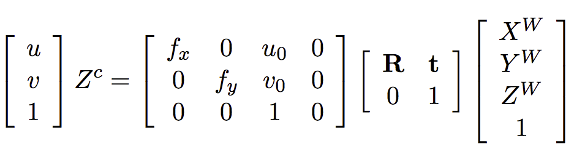

Note the use of homogenous coordinates to represent the point position vector and camera pixel projection vector: this allows for the effects of both rotation and translation between reference frames to be represented in a single set of matrices, and transformation be represented by matrix multiplication.

To determine pixel coordinates in a real, lens-distorted image, these equations are followed by a parametric model for radial and tangential distortion to arrive at the real, distorted pixel coordinate in the image (ud,vd):

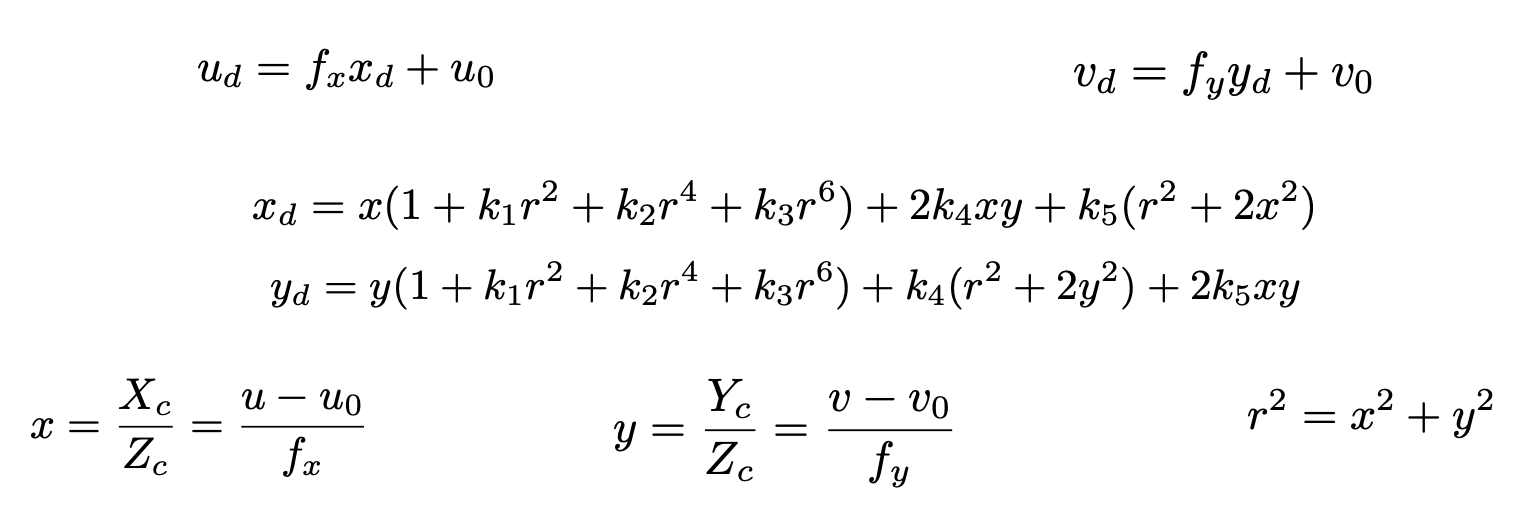

## 2. Single Camera Calibration

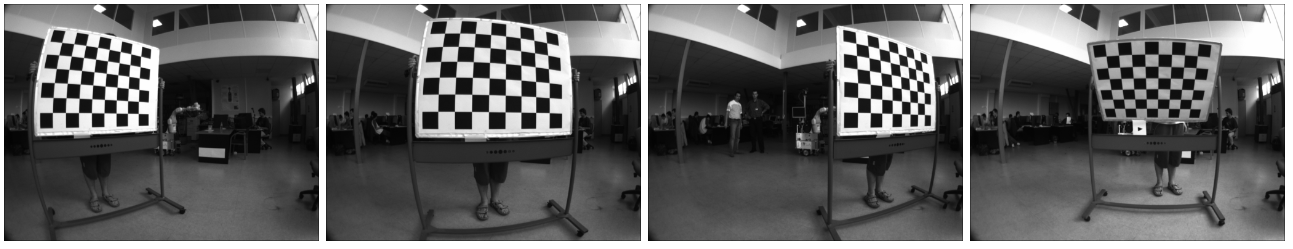

Camera calibration is the process of determining the intrinsic parameters of the camera (the focal lengths (fx, fy) and principle point (u0, v0)) and lens distortion coefficients (k1, k2, k3, k4, k5). During the tutorial, you will perform a calibration routine using a set of images captured using a stereo camera system. The file “stereo_calibration_images.zip” contains images from a stereo camera, captured during a calibration routine of a stereo camera system attached to the Dala robot (courtesy of LAAS-CNRS). To begin with, we will explore the process for calibrating a single camera (the left camera of the stereo pair).

The calibration process uses a series of images captured by the camera of a common object with known 3D structure. Using knowledge of the 3D point coordinates of an object alongside the measured 2D image coordinates of each corresponding point in a number of images, it becomes possible to formulate an optimisation for the camera calibration parameters which best "fit" the series of measurements.

One way to achieve this is with the use of a calibration checkerboard (see images above): relative to the checkerboard itself, the 3D locations of the corners of the checkerboard are known (they form a regular, flat grid in x-y coordinates, where z=0). By taking images of the checkerboard from various perspectives and detecting the corner locations in image coordinates, the 2D-3D point pairs can be used to determine the camera parameters.

## Detecting Checkerboard Corners

OpenCV provides a function designed exactly for this purpose "cv2.findChessboardCorners":
```
ret, corners = cv2.findChessboardCorners(img, grid_size, flags)
```
the function takes in a grayscale image "img" and specifications for the number of corners on the board in the horizontal and vertical directions "grid_size". The function uses a Harris corner detector to locate points, and returns only those points that appear to fit a regular grid. The return value "ret" indicate whether or not all corners were successfully located, with corner locations specified in "corners". These corners can be passed to the OpenCV function "cv2.cornerSubPix" which refines their locations using a sub-pixel refinement algorithm.

The function "cv2.drawChessboardCorners" can be used to visualise the detected corners.

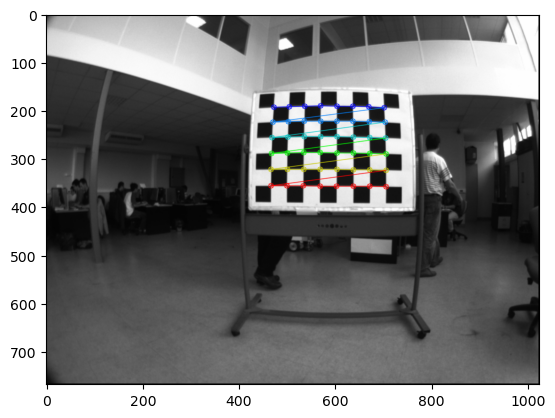

In [59]:
# Load an example image from the stereo images
img = cv2.imread("stereo_calibration_images/left/image0000.pgm", cv2.IMREAD_GRAYSCALE)
grid_size = (8,6) # (horizontal, vertical) number of corners on board

# detect and refine corners
ret, corners = cv2.findChessboardCorners(img, grid_size, None)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
window_search = (11,11)
corners2 = cv2.cornerSubPix(img, corners, window_search, (-1,-1), criteria)

# Draw and display the corners
imgc = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # create 3-channel image for drawing on
cv2.drawChessboardCorners(imgc, grid_size, corners2, ret)

plt.imshow(imgc)

The location and order of corners are displayed using colours from blue to red.

The (x,y,z) 3D locations of each of these detected corners can be constructed from the known properties of the grid, in a coordinate system that begins at the location of the first point, and has x-y coordinates lined along the grid. For example, the following code constructs a numpy array of the coordinates, where "cell_size" is the measured size of each checkboard square:

In [60]:
# Build numpy array containing (x,y,z) coordinates of corners, relative to board itself
cell_size = 0.116 # size of each checkerboard square (116mm for board shown above) (in meters)
pattern_points = np.zeros((np.prod(grid_size), 3), np.float32)
pattern_points[:, :2] = np.indices(grid_size).T.reshape(-1, 2) # fill-in X-Y points of grid
pattern_points = cell_size*pattern_points # scale by the size of each grid cell

print('3D coordinates of checkerboard corners:')
print(pattern_points)

3D coordinates of checkerboard corners:
[[0.    0.    0.   ]
 [0.116 0.    0.   ]
 [0.232 0.    0.   ]
 [0.348 0.    0.   ]
 [0.464 0.    0.   ]
 [0.58  0.    0.   ]
 [0.696 0.    0.   ]
 [0.812 0.    0.   ]
 [0.    0.116 0.   ]
 [0.116 0.116 0.   ]
 [0.232 0.116 0.   ]
 [0.348 0.116 0.   ]
 [0.464 0.116 0.   ]
 [0.58  0.116 0.   ]
 [0.696 0.116 0.   ]
 [0.812 0.116 0.   ]
 [0.    0.232 0.   ]
 [0.116 0.232 0.   ]
 [0.232 0.232 0.   ]
 [0.348 0.232 0.   ]
 [0.464 0.232 0.   ]
 [0.58  0.232 0.   ]
 [0.696 0.232 0.   ]
 [0.812 0.232 0.   ]
 [0.    0.348 0.   ]
 [0.116 0.348 0.   ]
 [0.232 0.348 0.   ]
 [0.348 0.348 0.   ]
 [0.464 0.348 0.   ]
 [0.58  0.348 0.   ]
 [0.696 0.348 0.   ]
 [0.812 0.348 0.   ]
 [0.    0.464 0.   ]
 [0.116 0.464 0.   ]
 [0.232 0.464 0.   ]
 [0.348 0.464 0.   ]
 [0.464 0.464 0.   ]
 [0.58  0.464 0.   ]
 [0.696 0.464 0.   ]
 [0.812 0.464 0.   ]
 [0.    0.58  0.   ]
 [0.116 0.58  0.   ]
 [0.232 0.58  0.   ]
 [0.348 0.58  0.   ]
 [0.464 0.58  0.   ]
 [0.58  0.58  0

## Camera Calibration/Parameter Optimisation

The process for determining 2D-3D point pairs is repeated for several images taken by the same camera, from a variety of perspectives of the checkerboard (approximately 10-20 images). OpenCV provides a function that can then be used to perform the calibration parameter optimisation from these pairs:
```
output = cv2.calibrateCameraExtended(pattern_points_list, corners_list, (w,h), Kmatrix_guess, dist_coeff_guess)
```
where "pattern_points_list" is a list of numpy arrays, where each element represents the 3D checkerboard points for each calibration image, "corners_list" is a list of numpy arrays, where each elements represents the extract 2D checkerboard corners, and (w,h) are the image dimensions.

This function also allows for an initial guess of the camera parameters (Kmatrix_guess is the initial intrinsic matrix and dist_coeff_guess the distorion coefficients), however these should be set to "None" is no prior information is available.

The output of this function is a tupel consisting of:
- ret: the overall root-mean-squared residual error of the optimisation
- K: the estimated intrinsic matrix of the camera
- d: the estimated distortion coefficients (k1, k2, k3, k4, k5)
- rvec: a list of estimated camera rotations for each image
- tvec: a list of estimated camera translations for each image
- stdDeviationsIntrinsics: estimated standard deviation of errors in intrinsic parameters
- stdDeviationsExtrinsics: estimated standard deviation of errors in extrinsic parameters (rvec, tvec)
- perViewErrors: average residual error magnitude for each input camera view

The output "perViewErrors" errors (measured in pixels) provides a good indication of which calibration images fit well with the estimated parameters. A large average residual error can be an indication that the corresponding calibration image does not fit well with the data and calibration performance could be improved by removing it from the process. This might occur, for example, if the checkerboard corner extraction has not performed properly on one or more of the images.

In this case, you should consider removing the image from the process and repeating the optimisation proceedure to check if residual errors can be decreased; there will be some engineering judgement in the balance between removing offending views, but maintaining enough views for an accurate calibration that works effectively for pixel coordinate across the whole image. In general, it is not unreasonable to attempt to achieve sub-pixel reprojection errors in a well-performed calibration.


## Image undistortion

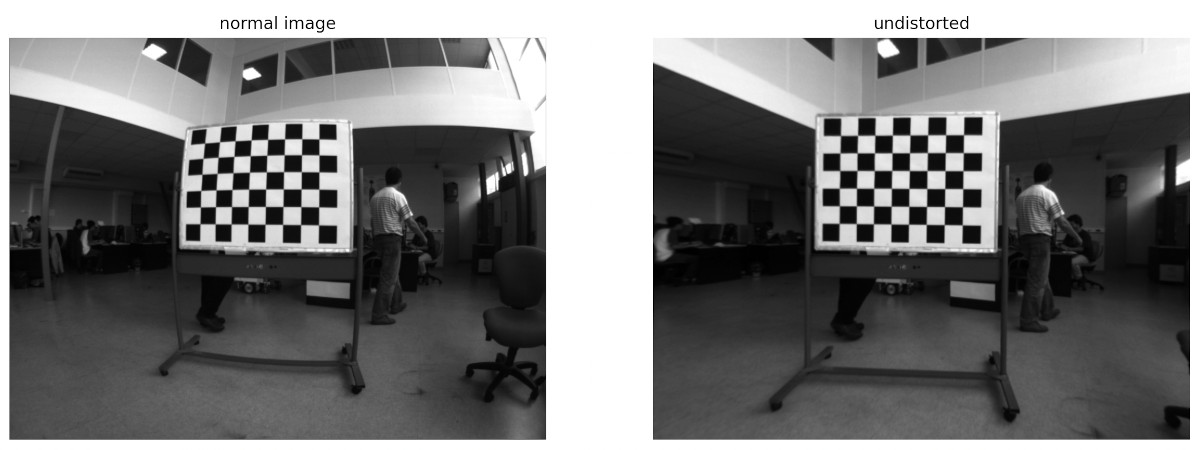

Once the camera calibration parameters are known, these can be used to produce an undistorted camera image, which is a re-mapping of the image pixel locations for a camera with the same intrinsic parameters, but with zero values for all distortion parameters.

In image can be undistorted using the function "undistort":
```
img_undistorted = cv2.undistort(img, K, d)
```
where "K" is the estimated intrinsic matrix and "d" are the distortion coefficient of the camera. Note that undistorting the image in this way means that some pixels in the original image might map to image coordinates that lie outside of the image boundaries (lost pixels). It is also possible that there will exist pixels in the new (undistorted) image coordinates that were outside of the orignal (distorted) image boundaries, and for which no data exists (unmeasured pixels): in this second case, OpenCV will render black (zero-valued) pixels to these regions.

Points in distorted image coordinates (ud,vd) can also be converted into undistorted image coordinates (u,v) by using the function "cv2.undistortPoints":
```
points_undist = cv2.undistortPoints(points, K, d)
```
where "points" is a 2xN numpy array of point locations. By default, OpenCV provides back undistorted points in normalised image coordinates (x,y) (see Week 5 lecture slides). These can then be converted into pixel coordinates by multiplying each point by the intrisic matrix K of the camera. OpenCV also provides an interface into "undistortPoints" that can perform this for you:
```
points_undist = cv2.undistortPoints(points, K, d, None, K)
```
where by providing the last arguement with the intrinsic matrix, the function performs this multiplication for you internally, such that the returned "points_undist" will be the points in undistorted image coordinates (u,v) in pixels.


## Projecting a 3D point to a 2D pixel location

Once the calibration parameters for a camera are known, these can be used to project the location of a 3D point (X,Y,Z) from the camera's reference frame into pixel coordinates (u,v) (i.e. where would that point appear in the image space. The complete projection calculation is shown in the Introduction above (also see Week 5 lecture). If the 3D point is measured relative the the camera reference frame, then the rotation matrix and translation vector (R,t) would be the identity matrix and a zero-vector respectively, however if measuring the coordinates (X,Y,Z) relative to another reference frame, then these parameters represent the transformation from that frame to the camera reference frame.

OpenCV provides a function "cv2.projectPoints" which can perform this calculation, while additionally performing distortion parameter mapping (i.e. second equation above):
```
(image_points, J) = cv2.projectPoints(points_3d, R, t, K, d)
```
where "points_3d" is a 3xN numpy array of (X,Y,Z) coordinates, and (R,t,K,d) represent the extrinsic, intrinsic and distortion cooeficients for the camera.

## 3. Stereo Camera Calibration

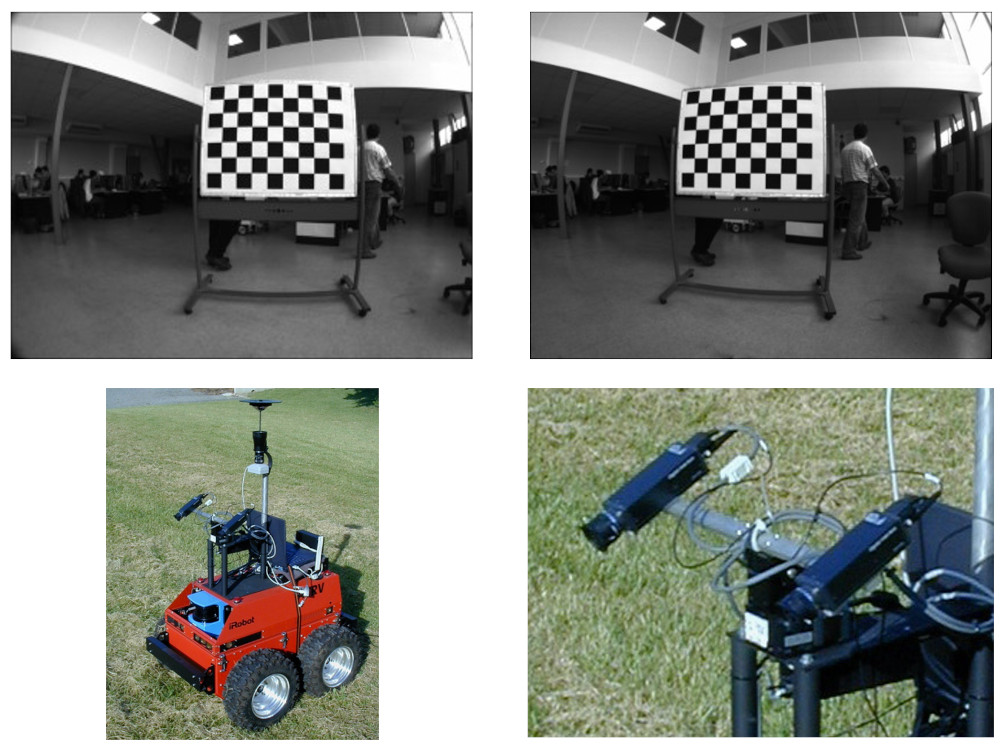

A stereo image system consists of two cameras that are rigidly-mounted to one another with a “baseline” distance between them, share a (roughly) common view and can be synchronously triggered. The calibration of a stereo-imaging system works in a similar fashion as for a single camera except that in addition to the single camera parameters, the extrinsic relative rotation matrix and translation vector (R and t) between the two cameras is also estimated.

For stereo camera calibration, the calibration process relies on a set of image pairs (one image from the “left” camera and one from the “right” camera), each view containing the checkboard, and captured from a range of different perspectives. 

OpenCV provides the function "cv2.stereoCalibrate" which can perform the estimation of all stereo camera parameters, including the single camera parameters for both the left and right cameras, and the rotation/translation between the cameras:
```
output = cv2.stereoCalibrate(pattern_points_list, corners_list_left, corners_list_right, Kleft_guess, Kright_guess, dleft_guess, dright_guess, (w,h), flags=0)
```
where "pattern_points_list" is a list of common 3D points for each camera pair, and "corners_list_left", "corners_list_right" are the list of extracted corners for left and right cameras respectively. The function allowed the user to specified pre-calibrated values for each camera (Kleft_guess, Kright_guess, dleft_guess, dright_guess) however, for normal calibration proceedures, these should all be set to "None" and will be estimated by the function (jointly with extrinsic parameters). "flags" can be used to control options in the calibration process, and can be set to zero for standard calibrations.

The function returns a tuple:
- err: overall root-mean-squared residual error of the optimisation
- Kleft: left camera intrinsic matrix
- dleft: left camera distortion parameters
- Kright: right camera intrinsic matrix
- dright: right camera distortion parameters
- R: rotation matrix of the right camera, relative to the camera frame for the left camera
- t: translation parameter for the right camera, relative to the camera frame for the left camera
- E: estimated essential matrix
- F: estimated fundamental matrix


## 4. Stereo Triangulation

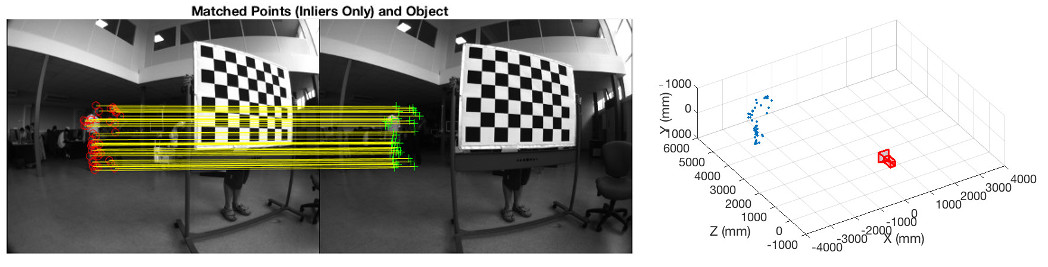

Stereo triangulation is the process of determining the 3D point coordinates of an common point viewed across a pair of stereo images, using the pixel coordinates in each view and knowledge of the stereo camera calibration parameters. OpenCV provides a function "cv2.triangulatePoints" which can perform triangulation:
```
points_3D = cv2.triangulatePoints(Pleft, Pright, pts_left, pts_right)
```
where "pts_left" are the pixel coordinates of points from the left camera, "pts_right" the pixel coordinates of the points from the right camera, and Pleft, Pright are the Projection Matrices for each camera. For triangulating 3D point coordinates relative to the left camera's reference frame, these projection matricies can be calculated as:

$\mathbf{P}_{left} = \mathbf{K}_{left}[I_{3x3} | 0_{3x1}]$

$\mathbf{P}_{right} = \mathbf{K}_{right}[\mathbf{R} | t]$

where (R,t) are the extrinsic parameter of the right camera (relative to the left). The projection matrices are therefore 3x4 dimensioned matrices that convert from homogenous world point coordinates (4D vectors) to homogenous image coordinates (3D vectors).

The output points "points_3D" will be in homogenous coordinates (i.e. each point will be a 4x1 vector): to recover the 3D point coordinates, you can scale (divide) the 4x1 vector by the last (4th) coordinate to recover the 3D (X,Y,Z) coordinates:
```
points_3D = points_3D/points_3D[3]
points_3D = points_3D[:3,:]
```


## 5. Feature Extraction, Matching and Triangulation

In the Week 4 lecture, we explored different types of feature points including algorithms for feature detection, descriptors and matching across images. In the following example we will develop code for extracting and matching features (using the ORB feature detector/descriptor) across a stereo pair, which can then be used for stereo triangulation.

To begin with we will load some example views (captued using a different stereo camera setup) and use the function "cv2.ORB_create" and "cv2.detectAndCompute" to extract images features from each view:

found 1000 and 1000 feature points ...


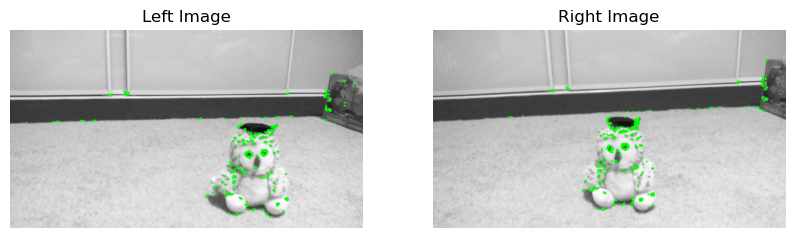

In [61]:
# Load image and extract ORB features
imgl = cv2.imread("stereo_calibration_images/others/owl_left.png", cv2.IMREAD_GRAYSCALE)
imgr = cv2.imread("stereo_calibration_images/others/owl_right.png", cv2.IMREAD_GRAYSCALE)

# Extract features
orb = cv2.ORB_create(nfeatures=1000) # "nfeatures" controls the sensitivity of how many features we want to extract
kp1, des1 = orb.detectAndCompute(imgl,None) # second parameter is a mask image (only extract points inside mask)
kp2, des2 = orb.detectAndCompute(imgr,None)
print('found %d and %d feature points ...'%(len(kp1),len(kp2)))
# kp: keypoints (image location of feature), des: descriptor: ORB feature descriptor for each keypoint

# draw located keypoints
imglc = cv2.cvtColor(imgl, cv2.COLOR_GRAY2RGB)
imgrc = cv2.cvtColor(imgr, cv2.COLOR_GRAY2RGB)
for k in kp1:
    cv2.circle(imglc,(int(k.pt[0]), int(k.pt[1])),3,(0,255,0),-1)
for k in kp2:
    cv2.circle(imgrc,(int(k.pt[0]), int(k.pt[1])),3,(0,255,0),-1)

plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(imglc,'Greys')
plt.title('Left Image')
plt.gca().set_axis_off()

plt.subplot(122)
plt.imshow(imgrc,'Greys')
plt.title('Right Image')
plt.gca().set_axis_off()

plt.show()

Next, we will compute matches between keypoints in each image based on their descriptors. In OpenCV, the "cv2.BFMatcher" (Brute-force matcher) can be used to do this by comparing distance between corresponding feature descriptor vectors in each image:

Found 409 matches ...


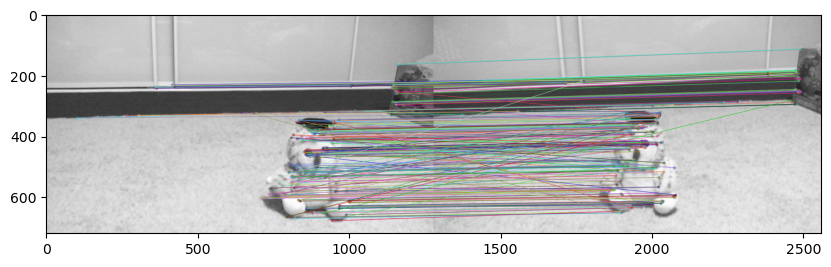

In [62]:
# initialise new matcher (cross-checker is used to only return matches that are the best in both views)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # for ORB (use distance "cv2.NORM_L2" for SIFT)

# Perform matching using extracted descriptors
# Each "match" contains information about distance and the index from image 1 (queryIdx) and image 2 (trainIdx)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance) # sort from best to worst
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

print('Found %d matches ...'%(len(matches)))

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(imgl,kp1,imgr,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

Looking at the identified correspondances, many of the displayed matches appear to be correct, however there are quite a few that do not look correct. A refined set of matches can be found by enforcing Epipolar constraints between the two views.

One way to achieve this (as discussed in the Week 4 and 5 lectures) is to use a RANSAC algorithm to compute the fundamental matrix between the two views, and discard outlier matches/correspondances that do not fit with the best identified fundamental matrix. This is performed via the function "cv2.findFundamentalMat":

Found 310 inlier correspondances


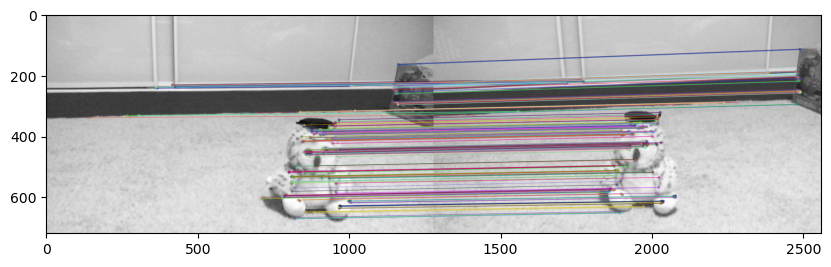

In [63]:
# compute Fundamental Matrix F between the two views using correspondances via RANSAC
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

# retain only points which were inliers (specified by "mask")
pts1_inliers = pts1[mask[:,0]==1]
pts2_inliers = pts2[mask[:,0]==1]

print("Found %d inlier correspondances"%(pts1_inliers.shape[0]))

# filter original matches list for re-drawing
matches_inliers = []
for i in range(mask.shape[0]):
    if mask[i,0] == 1:
        matches_inliers.append(matches[i])

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(imgl,kp1,imgr,kp2,matches_inliers,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

Notice that the remaining inlier correspondances are only those that satisfy the epipolar geometry of the two views: these will mostly be only the correct matches, however it is also possible that an incorrect match could still possibly satisfy these constraints (and remain as an inlier) if it happens to lie upon the epipolar lines between cameras.

In a stereo vision pipeline, these correspondaces could then be used to triangulate the located points in 3D space and build a 3D point cloud of objects in the scene in front of the camera. Note that if the images used during matching are the original distorted images, then point coordinates would need to be undistorted before being triangulated.

# Exercise/Activities to Complete
The following activities should be completed during the Friday tutorial and shown to your tutor to be marked off.


## Exercise 1: Single-Camera Calibration

The dataset of images in "stereo_calibration_images.zip" contains a series of image captued from a stereo camera system of a calibration checkerboard, which can be used for calibrating each camera. In this exercise, you will perform a single camera calibration proceedure for the left camera of the pair.
- Open up and explore the images in the sub-folder "left".
- Write code that extracts the calibration checkerboard coordinates for each camera image and stores in a list, while also building a list of the corresponding 3D points for each view.
- Use these to calibrate the camera (estimate the intrinsic matrix parameters and distortion parameters).
- Produce a plot of the residual errors for each input view, identify views to remove from the process and re-perform the calibration. Produce a plot of the residual errors afterwards.
- Repeat this whole process for the right camera: the images for this camera are contained in the folder "right"
- Perform an undistortion of one or more of the camera images and note the differences between the distorted and undistorted images.

Text(0.5, 1.0, 'Without Residuals')

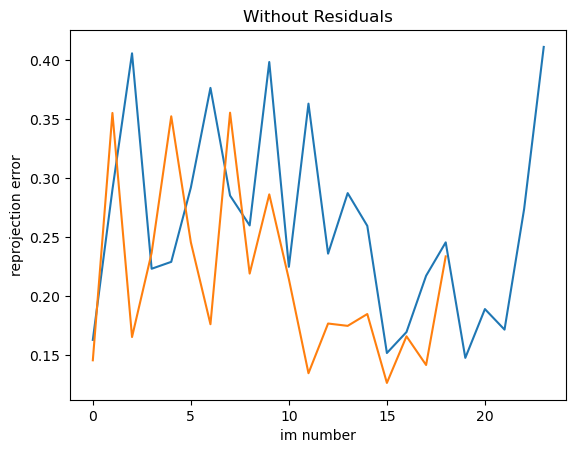

In [75]:
# Write your code here, or in a separate python script
import os


########################################################### LEFT CAMERA #########################################################################
# Extract checkerboard coordinates 
img_path = 'stereo_calibration_images/left'

# Load images of fleft chessboards
imgs = []
for i in range(24):
    imgs.append(cv2.imread(os.path.join(img_path,'image%04d.pgm'%(i)), cv2.IMREAD_GRAYSCALE))

grid_size = (8,6) # (horizontal, vertical) number of corners on board

all_left_corners = []

dim_points = []

# print(imgs)

# detect and refine corners
for i in range(24): 
    img = imgs[i]
    ret, corners = cv2.findChessboardCorners(img, grid_size, None)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    window_search = (11,11)
    corners2 = cv2.cornerSubPix(img, corners, window_search, (-1,-1), criteria)

    all_left_corners.append(corners2)

    # Build numpy array containing (x,y,z) coordinates of corners, relative to board itself
    cell_size = 0.116 # size of each checkerboard square (116mm for board shown above) (in meters)
    pattern_points = np.zeros((np.prod(grid_size), 3), np.float32)
    pattern_points[:, :2] = np.indices(grid_size).T.reshape(-1, 2) # fill-in X-Y points of grid
    pattern_points = cell_size*pattern_points # scale by the size of each grid cell

    dim_points.append(pattern_points)


# print(all_corners)

h, w = imgs[0].shape

# Conduct camera calibration 
_, K_left, d_left, _, _, _, _, perViewErrors = cv2.calibrateCameraExtended(dim_points, all_left_corners, (w,h), None, None)




plt.plot(perViewErrors)
plt.xlabel("im number")
plt.ylabel("reprojection error")
plt.title("Reprojection errors for Left Dataset")


left_filtered_corners = []
left_filtered_points = []


new_imgs = []
for i in range(24):
    if ( i!= 1 and i!= 4 and i!= 7 and i!= 9 and i!= 24):
        new_imgs.append(cv2.imread(os.path.join(img_path,'image%04d.pgm'%(i)), cv2.IMREAD_GRAYSCALE))



new_left_corners = []

new_left_points = []

# detect and refine corners
for i in range(19): 
    img = new_imgs[i]
    ret, corners = cv2.findChessboardCorners(img, grid_size, None)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    window_search = (11,11)
    corners2 = cv2.cornerSubPix(img, corners, window_search, (-1,-1), criteria)

    new_left_corners.append(corners2)

    # Build numpy array containing (x,y,z) coordinates of corners, relative to board itself
    cell_size = 0.116 # size of each checkerboard square (116mm for board shown above) (in meters)
    pattern_points = np.zeros((np.prod(grid_size), 3), np.float32)
    pattern_points[:, :2] = np.indices(grid_size).T.reshape(-1, 2) # fill-in X-Y points of grid
    pattern_points = cell_size*pattern_points # scale by the size of each grid cell

    new_left_points.append(pattern_points)


# print(all_corners)

h, w = imgs[0].shape

# Conduct camera calibration 
_, K, d, _, _, _, _, perViewErrors = cv2.calibrateCameraExtended(new_left_points, new_left_corners, (w,h), None, None)



plt.plot(perViewErrors)
plt.xlabel("im number")
plt.ylabel("reprojection error")
plt.title("Without Residuals")





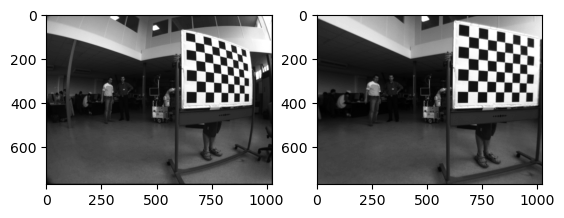

In [65]:
# Undistortion 

img_left = cv2.imread("stereo_calibration_images/left/image0002.pgm", cv2.IMREAD_GRAYSCALE)

img_undistorted_left = cv2.undistort(img_left, K, d)

plt.subplot(121)
plt.imshow(img_left, 'gray')
plt.subplot(122)
plt.imshow(img_undistorted_left, cmap='gray')

Text(0.5, 1.0, 'Without Residuals')

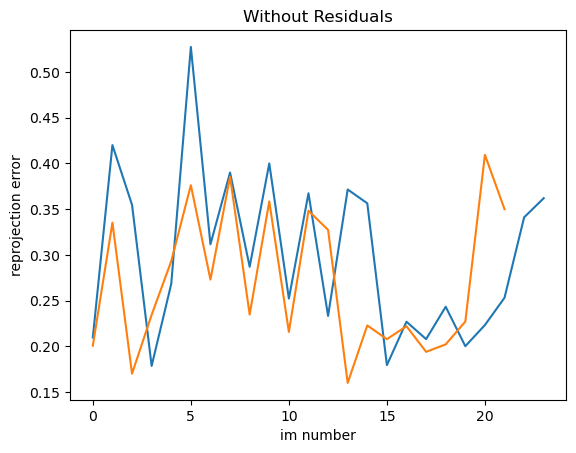

In [66]:
##################################################### RIGHT IMAGES ##########################################################################################

# Extract checkerboard coordinates 
img_path = 'stereo_calibration_images/right'

# Load images of fleft chessboards
imgs = []
for i in range(24):
    imgs.append(cv2.imread(os.path.join(img_path,'image%04d.pgm'%(i)), cv2.IMREAD_GRAYSCALE))

grid_size = (8,6) # (horizontal, vertical) number of corners on board

all_right_corners = []

dim_points = []

# print(imgs)

# detect and refine corners
for i in range(24): 
    img = imgs[i]
    ret, corners = cv2.findChessboardCorners(img, grid_size, None)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    window_search = (11,11)
    corners2 = cv2.cornerSubPix(img, corners, window_search, (-1,-1), criteria)

    all_right_corners.append(corners2)

    # Build numpy array containing (x,y,z) coordinates of corners, relative to board itself
    cell_size = 0.116 # size of each checkerboard square (116mm for board shown above) (in meters)
    pattern_points = np.zeros((np.prod(grid_size), 3), np.float32)
    pattern_points[:, :2] = np.indices(grid_size).T.reshape(-1, 2) # fill-in X-Y points of grid
    pattern_points = cell_size*pattern_points # scale by the size of each grid cell

    dim_points.append(pattern_points)


# print(all_corners)

h, w= imgs[0].shape

# Conduct camera calibration 
_, K_right, d_right, rvec_right, tvec_right, _, _, perViewErrors = cv2.calibrateCameraExtended(dim_points, all_right_corners, (w,h), None, None)



plt.plot(perViewErrors)
plt.xlabel("im number")
plt.ylabel("reprojection error")
plt.title("Reprojection errors for Right Dataset")


new_imgs = []
for i in range(24):
    if ( i!= 1 and i!= 5):
        new_imgs.append(cv2.imread(os.path.join(img_path,'image%04d.pgm'%(i)), cv2.IMREAD_GRAYSCALE))



new_right_corners = []

new_right_points = []

# detect and refine corners
for i in range(22): 
    img = new_imgs[i]
    ret, corners = cv2.findChessboardCorners(img, grid_size, None)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    window_search = (11,11)
    corners2 = cv2.cornerSubPix(img, corners, window_search, (-1,-1), criteria)

    new_right_corners.append(corners2)

    # Build numpy array containing (x,y,z) coordinates of corners, relative to board itself
    cell_size = 0.116 # size of each checkerboard square (116mm for board shown above) (in meters)
    pattern_points = np.zeros((np.prod(grid_size), 3), np.float32)
    pattern_points[:, :2] = np.indices(grid_size).T.reshape(-1, 2) # fill-in X-Y points of grid
    pattern_points = cell_size*pattern_points # scale by the size of each grid cell

    new_right_points.append(pattern_points)


# print(all_corners)

h, w = imgs[0].shape

# Conduct camera calibration 
_, K, d, _, _, _, _, perViewErrors = cv2.calibrateCameraExtended(new_right_points, new_right_corners, (w,h), None, None)



plt.plot(perViewErrors)
plt.xlabel("im number")
plt.ylabel("reprojection error")
plt.title("Without Residuals")





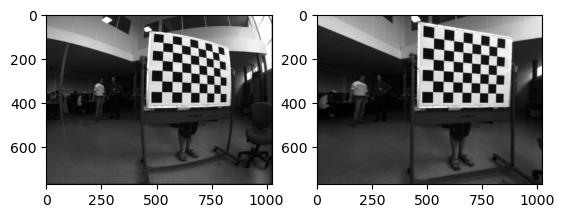

In [67]:
img_right = cv2.imread("stereo_calibration_images/right/image0002.pgm", cv2.IMREAD_GRAYSCALE)

img_undistorted_right = cv2.undistort(img_right, K, d)

plt.subplot(121)
plt.imshow(img_right, 'gray')
plt.subplot(122)
plt.imshow(img_undistorted_right, cmap='gray')

## Exercise 2: Stereo Camera Calibration

- Open up the images for both the left and right cameras in the "stereo_calibration_images" folders.
- Perform a stereo parameter calibration for the camera pair. You may need to leave out camera views that results in poor results (i.e. outliers) from either of the left or right cameras that you identified during Exercise 1.
- Have a look at the calibration parameters of the cameras: what is the distance between the optical center of the left and right cameras (i.e. their baseline distance?)

In [68]:
# Write your code here, or in a separate python script

retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv2.stereoCalibrate(dim_points, all_left_corners, all_right_corners, None, None, None, None, (w,h), flags=0)

print(T)

print(R)


[[-0.33103833]
 [-0.00106142]
 [ 0.00509337]]
[[ 9.99841614e-01 -6.79614928e-03  1.64486968e-02]
 [ 6.81265382e-03  9.99976345e-01 -9.47568662e-04]
 [-1.64418679e-02  1.05947786e-03  9.99864262e-01]]


## Exercise 3: 3D Point Projection into Images

- Open up "image0002.pgm". Within this stereo pair, the world point p = [-4897, -35, 5411] mm (measured in the frame of reference attached to the first/left camera) corresponds to a certain object in the scene. Project this 3D point back into each of the two cameras in the stereo pair and plot the pixel coordinates of the point on top of both images. What physical object in the scene does this point correspond to?
- To find out, you should pass the 3D point through the projection equation incorporating the intrinsics and extrinsics for each camera. Start off by computing the undistorted pixel coordinate in each camera using the point position and the calibrated intrinsic and extrinsic parameters of the stereo pair (see equations above in Introduction). Compare this calculated point to the undistorted images for both the left and right cameras.
- You can also use the function "cv2.projectPoints" to calculate this projection for you. Try using this function to project this world 3D point into the left and right distorted image views to locate the same point.
- Produce plots/figures of your different re-projections.


[[516.18210714   0.         580.16015548]
 [  0.         517.19438943 372.10083548]
 [  0.           0.           1.        ]]
[[-3.17411194e-01  1.15658484e-01  8.41802381e-04  1.56434441e-04
  -2.03688523e-02]]


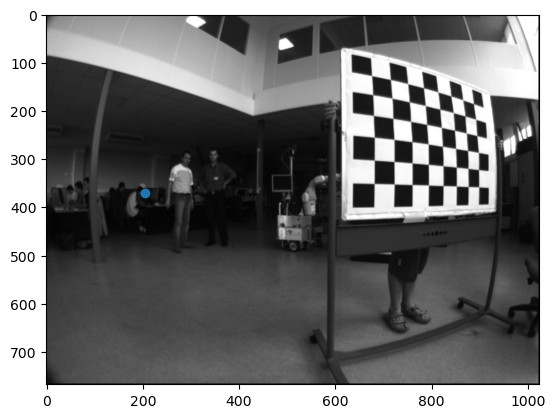

In [69]:
# Write your code here, or in a separate python script

left_im = cv2.imread("stereo_calibration_images/left/image0002.pgm", cv2.IMREAD_GRAYSCALE)

right_img = cv2.imread("stereo_calibration_images/right/image0002.pgm", cv2.IMREAD_GRAYSCALE)

point_3d = np.array([[-4.897, -0.035, 5.411]], dtype=np.float32)

# Identity matrix and matrix of zeros 
R_left = np.eye(3)
T_left = np.zeros(3)

print(K_left)

print(d_left)

(left_points, left_J) = cv2.projectPoints(point_3d, R_left, T_left, K_left, d_left)

(right_points, right_J) = cv2.projectPoints(point_3d, R, T, K_right, d_right)



x, y = left_points[0, 0]

plt.imshow(left_im, 'gray')
plt.scatter(x, y)



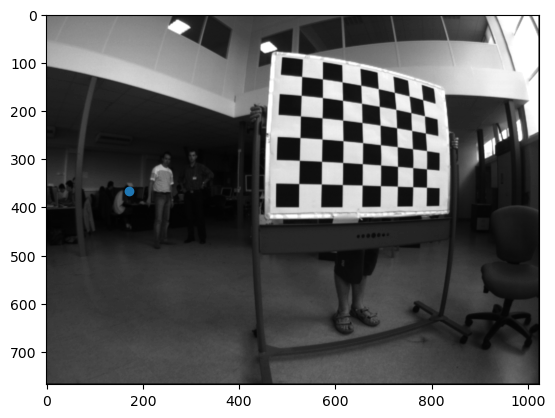

In [70]:
x, y = right_points[0, 0]

plt.imshow(right_img, 'gray')
plt.scatter(x, y)


## Exercise 4: Stereo Triangulation

- Load in the left and right images for the image file "image0002.pgm".
- Try extracting ORB features across both images and determine correspondances as shown in Section 5 above. What do you notice about features on the checkerboard?
- Try now extracting and matching ORB features from just a specific Region Of Interest (ROI) in each image: for the left camera, find features within a box specified by (x,y,w,h) = [230,260,190,260] pixels by creating a rectangular mask that is provided as the second arguement to "orb.detectAndCompute". For the right image, try specifying an ROI that takes up the left third of the image (i.e. (x,y,w,h) = [1,1,w/3,h].
- Repeat you matching proceedure: experiment with extract more or less features using the "nfeatures" parameter when detecting features.
- Use the inlier correspondances and calibrated stereo parameters to build a 3D point cloud of your extracted match points. Present a plot of your 3D points and determine the average distance of these points to the camera.


found 212 and 178 feature points ...


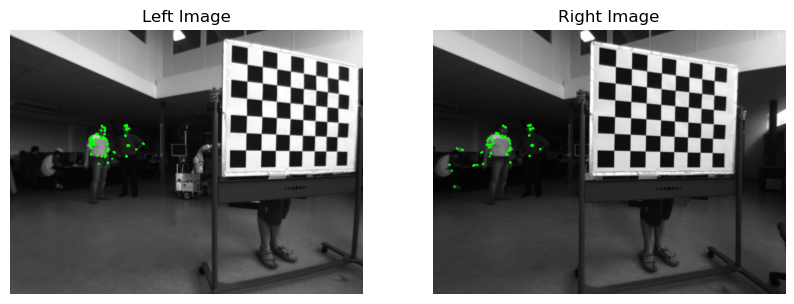

In [163]:
# Write your code here, or in a separate python script

mask1 = np.zeros((h, w), dtype=np.uint8)
mask2 = np.zeros((h, w), dtype=np.uint8)

# Define left and right boxes
left_box = np.array([230, 260, 230+190, 260+260], dtype=np.int32)  
right_box = np.array([1, 1, int(1 + w/3), int(1 + h)], dtype=np.int32)

# Draw rectangles on masks
mask1[left_box[1]:left_box[3], left_box[0]:left_box[2]] = 255
mask2[right_box[1]:right_box[3], right_box[0]:right_box[2]] = 255

# Extract features
orb = cv2.ORB_create(nfeatures=1000) # "nfeatures" controls the sensitivity of how many features we want to extract
kp1, des1 = orb.detectAndCompute(img_undistorted_left, mask1) # second parameter is a mask image (only extract points inside mask)
kp2, des2 = orb.detectAndCompute(img_undistorted_right, mask2)
print('found %d and %d feature points ...'%(len(kp1),len(kp2)))
# kp: keypoints (image location of feature), des: descriptor: ORB feature descriptor for each keypoint

# draw located keypoints
imglc = cv2.cvtColor(img_undistorted_left, cv2.COLOR_GRAY2RGB)
imgrc = cv2.cvtColor(img_undistorted_right, cv2.COLOR_GRAY2RGB)
for k in kp1:
    cv2.circle(imglc,(int(k.pt[0]), int(k.pt[1])),3,(0,255,0),-1)
for k in kp2:
    cv2.circle(imgrc,(int(k.pt[0]), int(k.pt[1])),3,(0,255,0),-1)

plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.imshow(imglc,'Greys')
plt.title('Left Image')
plt.gca().set_axis_off()

plt.subplot(122)
plt.imshow(imgrc,'Greys')
plt.title('Right Image')
plt.gca().set_axis_off()

plt.show()




Found 88 matches ...


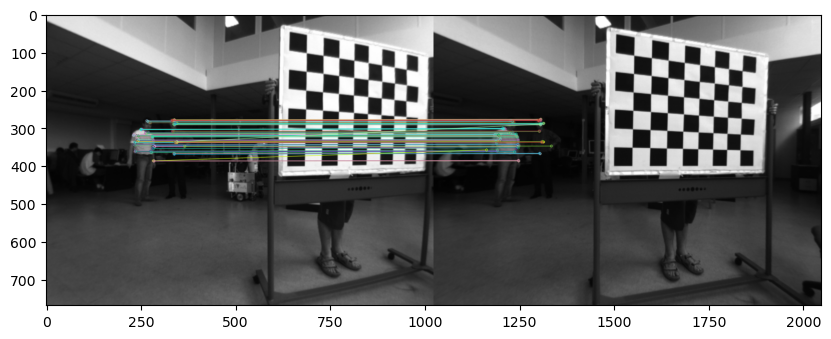

In [ ]:
# initialise new matcher (cross-checker is used to only return matches that are the best in both views)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) # for ORB (use distance "cv2.NORM_L2" for SIFT)

# Perform matching using extracted descriptors
# Each "match" contains information about distance and the index from image 1 (queryIdx) and image 2 (trainIdx)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance) # sort from best to worst
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

print('Found %d matches ...'%(len(matches)))

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(img_undistorted_left,kp1,img_undistorted_right,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsiz1000e=(10, 7))
plt.imshow(imgmatch)
plt.show()

Found 84 inlier correspondances


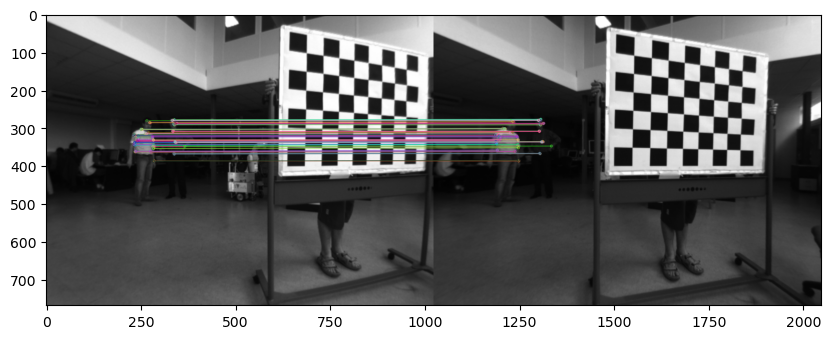

In [165]:
# compute Fundamental Matrix F between the two views using correspondances via RANSAC
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

# retain only points which were inliers (specified by "mask")
pts1_inliers = pts1[mask[:,0]==1]
pts2_inliers = pts2[mask[:,0]==1]

print("Found %d inlier correspondances"%(pts1_inliers.shape[0]))

# filter original matches list for re-drawing
matches_inliers = []
for i in range(mask.shape[0]):
    if mask[i,0] == 1:
        matches_inliers.append(matches[i])

# Display matches on screen using "cv2.drawMatches"
imgmatch = cv2.drawMatches(img_undistorted_left,kp1,img_undistorted_right,kp2,matches_inliers,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 7))
plt.imshow(imgmatch)
plt.show()

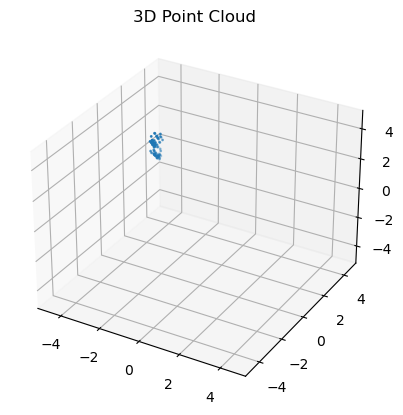

In [181]:
# Triangulation 


P_left = (K_left)@ np.hstack((np.eye(3), np.zeros((3, 1)))) 
P_right = (K_right) @ np.hstack((R, T))  

pts1_h = pts1_inliers.T.astype(np.float32)
pts2_h = pts2_inliers.T.astype(np.float32)

points_4D = cv2.triangulatePoints(P_left, P_right, pts1_h, pts2_h)

points_3D = points_4D/points_4D[3]
points_3D = points_3D[:3,:]

points_3D = points_3D.T


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], s=1)
ax.set_title("3D Point Cloud")
ax.set_ylim([-5,5])
ax.set_xlim([-5,5])
ax.set_zlim([-5,5])
plt.show()

